1. INSTALLS & IMPORTS

In [8]:
# Install libraries
# !pip install -q sentence-transformers scikit-learn umap-learn seaborn matplotlib pandas numpy

import re
import numpy as np
import pandas as pd
from dataclasses import dataclass

import matplotlib.pyplot as plt
import seaborn as sns

# ML & NLP Libraries
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Dimensionality Reduction
try:
    import umap.umap_ as umap
except ImportError:
    print("UMAP not available. Install 'umap-learn' to use UMAP visualizations.")
    umap = None

# Plotting Style
sns.set_theme(style="whitegrid", context="talk")

2. CONFIGURATION

In [9]:
# We use all-mpnet-base-v2 which performs well on short texts like keywords and for generating high-quality semantic embeddings.
# Clustering Logic: Sets the target number of topics (n_clusters=15) and fixes the random seed (42) so results remain consistent across runs.
# Data Cleaning: Establishes thresholds (minimum impressions) and regex patterns to filter out noise and brand-specific terms before processing.

@dataclass
class Config:
    # --- Clustering Settings ---
    # Enhanced model for short text
    embedding_model: str = "all-mpnet-base-v2"
    n_clusters: int = 15
    random_state: int = 42

    # --- Filtering ---
    min_impressions: int = 10  # Lowered for mock data example
    brand_regex: str = r""
    exclude_regex: str = r""

CFG = Config()

3. Data Loading & Processing

In [10]:
# Generate_mock_data: Create synthetic "Before" and "After" SEO datasets centered around specific
#topics (e.g., cremation, urns) to test the pipeline without needing a live API connection.
# data_a = previous period vs data_b = latest period

def generate_mock_data(n_rows=500):
    """Generates synthetic SEO data for testing."""
    # Seed topics for clustering coherence
    topics = ["cremation cost", "pet urns", "funeral services", "biodegradable caskets", "cremation jewelry"]
    data_a = []
    data_b = []

    for i in range(n_rows):
        topic = np.random.choice(topics)
        suffix = np.random.choice(["near me", "prices", "for dogs", "online", "reviews", "in california"])
        query = f"{topic} {suffix} {i}"

        # Period A Metrics
        imps_a = np.random.randint(100, 5000)
        clicks_a = int(imps_a * np.random.uniform(0.01, 0.15))
        pos_a = np.random.uniform(1.0, 60.0)

        # Period B Metrics (with random drift)
        imps_b = int(imps_a * np.random.uniform(0.8, 1.5))
        clicks_b = int(imps_b * np.random.uniform(0.01, 0.15))
        pos_b = pos_a + np.random.uniform(-5, 5)
        pos_b = max(1.0, pos_b)

        data_a.append({"query": query, "clicks": clicks_a, "impressions": imps_a, "ctr": clicks_a/imps_a if imps_a > 0 else 0, "position": pos_a})
        data_b.append({"query": query, "clicks": clicks_b, "impressions": imps_b, "ctr": clicks_b/imps_b if imps_b > 0 else 0, "position": pos_b})

    return pd.DataFrame(data_a), pd.DataFrame(data_b)

def clean_filter_queries(df: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    """Filters data based on regex and minimum impressions."""
    if df.empty: return df
    out = df.copy()
    if "query" in out.columns:
        out["query"] = out["query"].astype(str)
        if cfg.brand_regex:
            out = out[out["query"].str.contains(cfg.brand_regex, flags=re.I, regex=True, na=False)]
        if cfg.exclude_regex:
            out = out[~out["query"].str.contains(cfg.exclude_regex, flags=re.I, regex=True, na=False)]
    if "impressions" in out.columns:
        out = out[out["impressions"] >= cfg.min_impressions].copy()
    return out

def weighted_mean(values, weights):
    if sum(weights) == 0: return 0
    return np.average(values, weights=weights)

def aggregate_by_query(df: pd.DataFrame) -> pd.DataFrame:
    """Aggregates metrics by query."""
    grp_cols = [c for c in df.columns if c in ("period", "query")]
    agg = (df.groupby(grp_cols, as_index=False)
             .agg(clicks=("clicks", "sum"),
                  impressions=("impressions", "sum"),
                  position=("position", lambda x: weighted_mean(x, df.loc[x.index, "impressions"]))))
    agg["ctr"] = np.where(agg["impressions"] > 0, agg["clicks"] / agg["impressions"], 0.0)
    return agg

4. CLUSTERING LOGIC

In [14]:
# Perform semantic clustering & topic extraction: This block performs the core machine learning tasks to group search queries by intent rather than just keywords.
# Function iterates through data to determine the optimal number of clusters to optimize for silhouette score
# Performs vectorize and grouping: converts raw text into semantic vectors using K-means algorithm
# Output is clustered data with labels

def pick_k_auto(embeddings: np.ndarray, k_min=3, k_max=20, random_state=42):
    best = (None, -1)
    k_max = min(k_max, len(embeddings) - 1)
    if k_max <= k_min: return k_min, -1

    print("Auto-tuning cluster count (k)...")
    for k in range(k_min, k_max):
        km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
        labels = km.fit_predict(embeddings)
        try:
            score = silhouette_score(embeddings, labels)
            if score > best[1]: best = (k, score)
        except: continue
    return best

def cluster_queries(df_agg: pd.DataFrame, cfg: Config):
    queries = df_agg["query"].unique().tolist()
    if len(queries) < 5:
        print("Not enough queries to perform clustering.")
        return None, None, None, None

    print(f"Embedding {len(queries)} unique queries using {cfg.embedding_model}...")
    model = SentenceTransformer(cfg.embedding_model)
    emb = model.encode(queries, normalize_embeddings=True)

    if cfg.n_clusters is None:
        k, s = pick_k_auto(emb, random_state=cfg.random_state)
        print(f"Auto-picked k={k} (Silhouette Score={s:.3f})")
    else:
        k = min(cfg.n_clusters, len(queries)-1)
        print(f"Using fixed k={k}")

    km = KMeans(n_clusters=k, random_state=cfg.random_state, n_init="auto")
    labels = km.fit_predict(emb)

    q2c = dict(zip(queries, labels))
    out = df_agg.copy()
    out["cluster_id"] = out["query"].map(q2c)

    # --- Centroid Naming ---
    print("Naming clusters via Centroid query...")
    cluster_names = {}
    for cluster_id in range(k):
        cluster_indices = np.where(labels == cluster_id)[0]
        if len(cluster_indices) > 0:
            cluster_embs = emb[cluster_indices]
            center = km.cluster_centers_[cluster_id]
            sims = np.dot(cluster_embs, center)
            best_idx = np.argmax(sims)
            cluster_names[cluster_id] = queries[cluster_indices[best_idx]].upper()
        else:
            cluster_names[cluster_id] = f"CLUSTER_{cluster_id}"

    out["cluster_name"] = out["cluster_id"].map(cluster_names)
    return out, km, emb, model

5. METRICS LOGIC


In [15]:


def cluster_period_metrics(df_clustered: pd.DataFrame) -> pd.DataFrame:
    m = (df_clustered.groupby(["cluster_id", "cluster_name", "period"], as_index=False)
            .agg(clicks=("clicks", "sum"),
                 impressions=("impressions", "sum"),
                 position=("position", lambda x: weighted_mean(x, df_clustered.loc[x.index, "impressions"]))))
    m["ctr"] = np.where(m["impressions"] > 0, m["clicks"] / m["impressions"], 0.0)
    return m

def pivot_two_periods(cluster_m: pd.DataFrame) -> pd.DataFrame:
    p = cluster_m.pivot_table(
        index=["cluster_id", "cluster_name"],
        columns="period",
        values=["clicks", "impressions", "ctr", "position"],
        aggfunc="first"
    )
    p.columns = [f"{metric}_{period}" for metric, period in p.columns]
    p = p.reset_index()
    p.fillna(0, inplace=True)

    for metric in ["clicks", "impressions", "ctr", "position"]:
        if f"{metric}_A" in p.columns and f"{metric}_B" in p.columns:
            p[f"delta_{metric}"] = p[f"{metric}_B"] - p[f"{metric}_A"]

    # --- Scores ---
    p["opportunity_score"] = np.where(
        (p["delta_clicks"] > 0) & (p["delta_position"] < 0),
        p["delta_clicks"] + np.abs(p["delta_position"] * 10), 0
    )
    p["risk_score"] = np.where(
        (p["delta_clicks"] < 0) & (p["delta_position"] > 0),
        np.abs(p["delta_clicks"]) + (p["delta_position"] * 10), 0
    )

    clicks_scale = np.nanmedian(np.abs(p["delta_clicks"])) + 1e-9
    pos_scale = np.nanmedian(np.abs(p["delta_position"])) + 1e-9
    p["total_change_score"] = (np.abs(p["delta_clicks"]) / clicks_scale) + (np.abs(p["delta_position"]) / pos_scale)

    return p.sort_values("total_change_score", ascending=False)

6. VIZ FUNCTIONS


In [16]:
def plot_umap_clusters(embeddings: np.ndarray, labels: np.ndarray, cluster_names: dict, title: str, figsize=(14, 10), legend_loc=(1.05, 1), legend_fontsize=10, tick_fontsize=10):
    if umap is None: return
    print("Generating UMAP Projection...")
    scaled_data = StandardScaler().fit_transform(embeddings)
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', random_state=42)
    embedding_2d = reducer.fit_transform(scaled_data)

    plot_df = pd.DataFrame(embedding_2d, columns=['UMAP_1', 'UMAP_2'])
    plot_df['Cluster_ID'] = labels
    plot_df['Cluster_Name'] = plot_df['Cluster_ID'].map(cluster_names)

    plt.figure(figsize=figsize)
    sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='Cluster_Name', data=plot_df, palette=sns.color_palette("muted"), alpha=0.8, s=80)
    plt.title(title, fontsize=12)
    plt.legend(bbox_to_anchor=legend_loc, loc=2, borderaxespad=0., fontsize=legend_fontsize)
    plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    plt.tight_layout()
    plt.show()

def plot_delta_quadrant(pivoted: pd.DataFrame, title: str, text_fontsize=9, xlabel_fontsize=12, ylabel_fontsize=12):
    data = pivoted.copy()
    # Check if we have B data to plot, if not, fill with 0
    if 'impressions_B' not in data.columns: data['impressions_B'] = 0
    if 'impressions_A' not in data.columns: data['impressions_A'] = 0
    data['total_impressions'] = data['impressions_A'] + data['impressions_B']

    plt.figure(figsize=(14, 8))
    sns.scatterplot(data=data, x="delta_position", y="delta_clicks", size="total_impressions",
                    sizes=(100, 2000), hue="cluster_name", legend=False, alpha=0.7, palette="tab10")

    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.text(data["delta_position"].min()*0.9, data["delta_clicks"].max()*0.9, "OPPORTUNITY\n(Rank Up, Clicks Up)", color='green', weight='bold', fontsize=text_fontsize+2)
    plt.text(data["delta_position"].max()*0.9, data["delta_clicks"].min()*0.9, "RISK\n(Rank Down, Clicks Down)", color='red', weight='bold', ha='right', fontsize=text_fontsize+2)

    top_movers = data.sort_values("total_change_score", ascending=False).head(5)
    for i, row in top_movers.iterrows():
        plt.text(row["delta_position"], row["delta_clicks"], row["cluster_name"], fontsize=text_fontsize, weight='bold')

    plt.title(title, fontsize=16)
    plt.xlabel("Delta Position (Negative = Improvement)", fontsize=xlabel_fontsize)
    plt.ylabel("Delta Clicks (Positive = Growth)", fontsize=ylabel_fontsize)
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.show()

def plot_trajectory(cluster_m: pd.DataFrame, title: str, text_fontsize=9, xlabel_fontsize=8, ylabel_fontsize=8):
    periods = sorted(cluster_m["period"].unique())
    if len(periods) != 2: return
    A, B = periods

    fig, ax = plt.subplots(figsize=(14, 8))
    sns.scatterplot(data=cluster_m, x="position", y="clicks", size="impressions",
                    hue="cluster_name", style="period", markers={"A": "o", "B": "X"},
                    sizes=(100, 1500), alpha=0.7, ax=ax, legend=False, palette="tab10")

    A_df = cluster_m[cluster_m["period"] == A].set_index("cluster_id")
    B_df = cluster_m[cluster_m["period"] == B].set_index("cluster_id")
    joined = A_df[["cluster_name","clicks","position"]].join(B_df[["clicks","position"]], lsuffix=f"_{A}", rsuffix=f"_{B}")
    palette = sns.color_palette("tab10", n_colors=len(joined))

    for i, (idx, r) in enumerate(joined.iterrows()):
        plt.plot([r[f"position_{A}"], r[f"position_{B}"]], [r[f"clicks_{A}"], r[f"clicks_{B}"]], color=palette[i%len(palette)], linestyle='--', linewidth=1.5, alpha=0.6)
        ax.text(r[f"position_{B}"], r[f"clicks_{B}"], r["cluster_name"], fontsize=text_fontsize, weight="bold", color=palette[i%len(palette)])

    ax.invert_xaxis()
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Average Position (Lower is Better)", fontsize=xlabel_fontsize)
    ax.set_ylabel("Total Clicks", fontsize=ylabel_fontsize)
    plt.show()

Setup & Data Loading


In [17]:
# --- STEP 1: LOAD DATA ---
# Toggle this boolean to switch between Synthetic and Real Data
USE_SYNTHETIC_DATA = True

if USE_SYNTHETIC_DATA:
    print("Generating synthetic SEO data...")
    df_a_raw, df_b_raw = generate_mock_data(n_rows=500)
else:
    # --- OPTION: Load your own CSVs ---
    # Ensure your CSVs have columns: query, clicks, impressions, ctr, position
    print("Loading real data from CSV...")
    # df_a_raw = pd.read_csv("your_period_a.csv")
    # df_b_raw = pd.read_csv("your_period_b.csv")

    # Placeholder error to prevent crash if you run without uploading files
    if 'df_a_raw' not in locals():
        print("Error: CSV files not found. Reverting to synthetic data.")
        df_a_raw, df_b_raw = generate_mock_data(n_rows=500)

# Process Data
df_a = df_a_raw.copy(); df_a["period"] = "A"
df_b = df_b_raw.copy(); df_b["period"] = "B"
df_all = pd.concat([df_a, df_b], ignore_index=True)
df_all = clean_filter_queries(df_all, CFG)
df_agg = aggregate_by_query(df_all)

print(f"Data Loaded. Total unique queries: {df_agg['query'].nunique()}")

Generating synthetic SEO data...
Data Loaded. Total unique queries: 500


In [18]:
# --- STEP 2: CLUSTER & ANALYZE ---
df_clustered, kmeans, embeddings, model = cluster_queries(df_agg, CFG)

if df_clustered is not None:
    cluster_m = cluster_period_metrics(df_clustered)
    pivoted = pivot_two_periods(cluster_m)

    # Display Top Movers Table
    print("\n--- Top Clusters by Total Change ---")
    display(pivoted.head(10))

    # Create map for visualizations
    cluster_names_map = {id: name for id, name in pivoted.set_index('cluster_id')['cluster_name'].to_dict().items()}
else:
    print("Clustering failed. Check data.")

Embedding 500 unique queries using all-mpnet-base-v2...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Using fixed k=15
Naming clusters via Centroid query...

--- Top Clusters by Total Change ---


,cluster_id,cluster_name,clicks_A,clicks_B,ctr_A,ctr_B,impressions_A,impressions_B,position_A,position_B,delta_clicks,delta_impressions,delta_ctr,delta_position,opportunity_score,risk_score,total_change_score
1,1,BIODEGRADABLE CASKETS ONLINE 334,21451,26999,0.080018,0.085239,268078,316745,31.149556,31.686241,5548,48667,0.005221,0.536685,0.000000,0.000000,6.566997
11,11,CREMATION COST IN CALIFORNIA 286,3624,6036,0.063322,0.104543,57231,57737,29.897944,28.163647,2412,506,0.041221,-1.734297,2429.342967,0.000000,5.579756
14,14,FUNERAL SERVICES IN CALIFORNIA 423,2603,3331,0.080636,0.079024,32281,42152,23.631146,22.266612,728,9871,-0.001612,-1.364534,741.645339,0.000000,3.210937
4,4,CREMATION JEWELRY FOR DOGS 242,1850,2943,0.061801,0.087402,29935,33672,26.293212,25.190185,1093,3737,0.025601,-1.103027,1104.030271,0.000000,3.104162
9,9,PET URNS PRICES 396,4608,4318,0.090463,0.072809,50938,59306,30.413718,28.911341,-290,8368,-0.017654,-1.502377,0.000000,0.000000,3.019634
10,10,CREMATION JEWELRY REVIEWS 359,9437,10205,0.076683,0.072157,123065,141427,27.111271,28.180730,768,18362,-0.004526,1.069459,0.000000,0.000000,2.715604
2,2,PET URNS ONLINE 234,13338,15732,0.077630,0.080600,171815,195187,29.696704,29.569660,2394,23372,0.002970,-0.127044,2395.270437,0.000000,2.643932
7,7,FUNERAL SERVICES REVIEWS 426,3987,3846,0.075986,0.071568,52470,53739,26.700999,27.992944,-141,1269,-0.004418,1.291945,0.000000,153.919451,2.487431
8,8,FUNERAL SERVICES FOR DOGS 132,4413,5612,0.087244,0.095011,50582,59067,35.653389,36.204256,1199,8485,0.007766,0.550867,0.000000,0.000000,2.208669
12,12,CREMATION COST NEAR ME 485,9664,11043,0.093943,0.096431,102871,114517,31.854279,31.467166,1379,11646,0.002488,-0.387112,1382.871123,0.000000,2.092854


Generating UMAP Projection...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-2824661410.py:13: UserWarning: 
The palette list has fewer values (10) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='Cluster_Name', data=plot_df, palette=sns.color_palette("muted"), alpha=0.8, s=80)


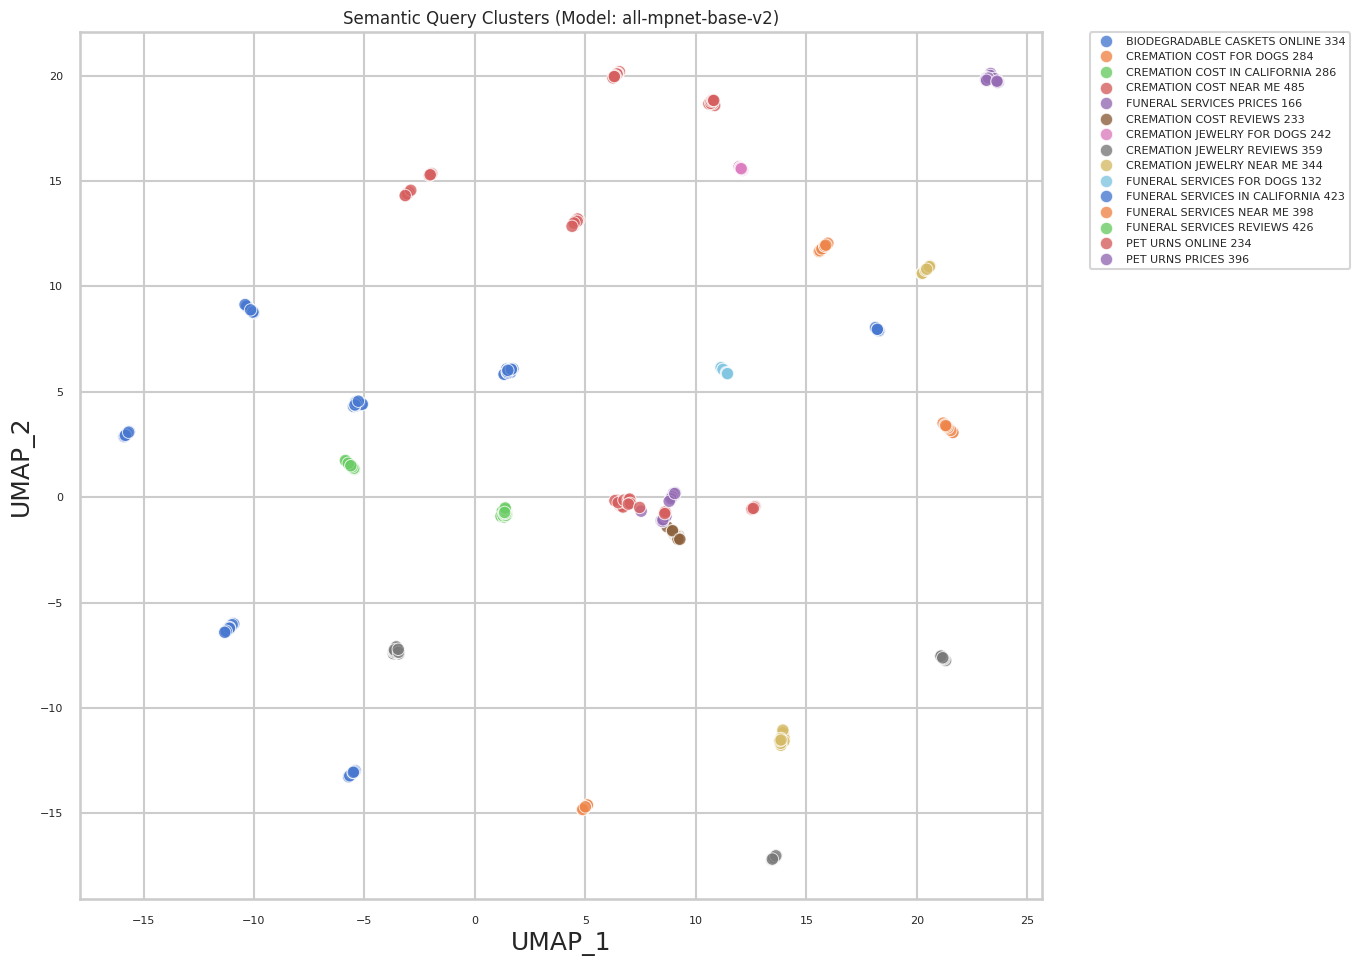

In [19]:
# Visual 1: Semantic Map
if df_clustered is not None:
    plot_umap_clusters(embeddings, kmeans.labels_, cluster_names_map, f"Semantic Query Clusters (Model: {CFG.embedding_model})", legend_fontsize=8, tick_fontsize=8)

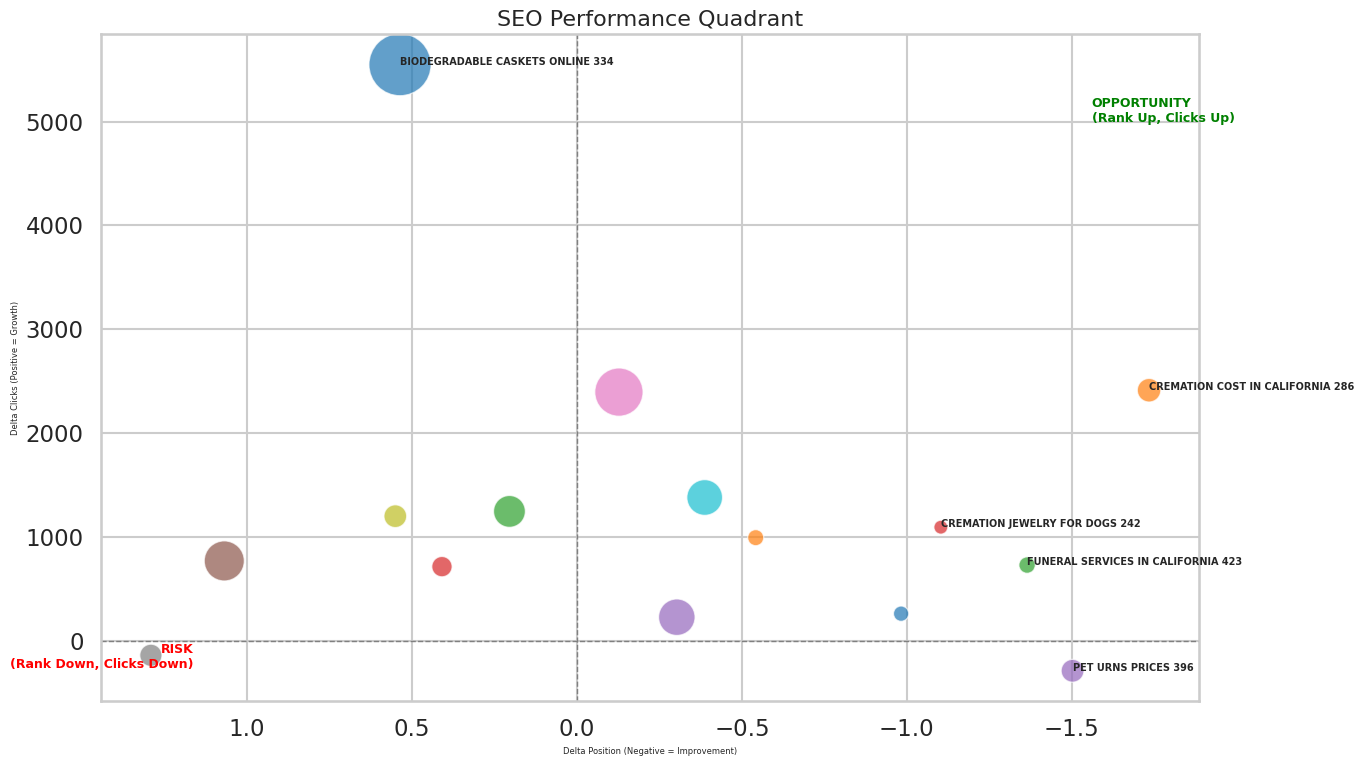

In [20]:
# Visual 2: Opportunity vs Risk Quadrant
if df_clustered is not None:
    plot_delta_quadrant(pivoted, "SEO Performance Quadrant", text_fontsize=7, xlabel_fontsize=6, ylabel_fontsize=6)

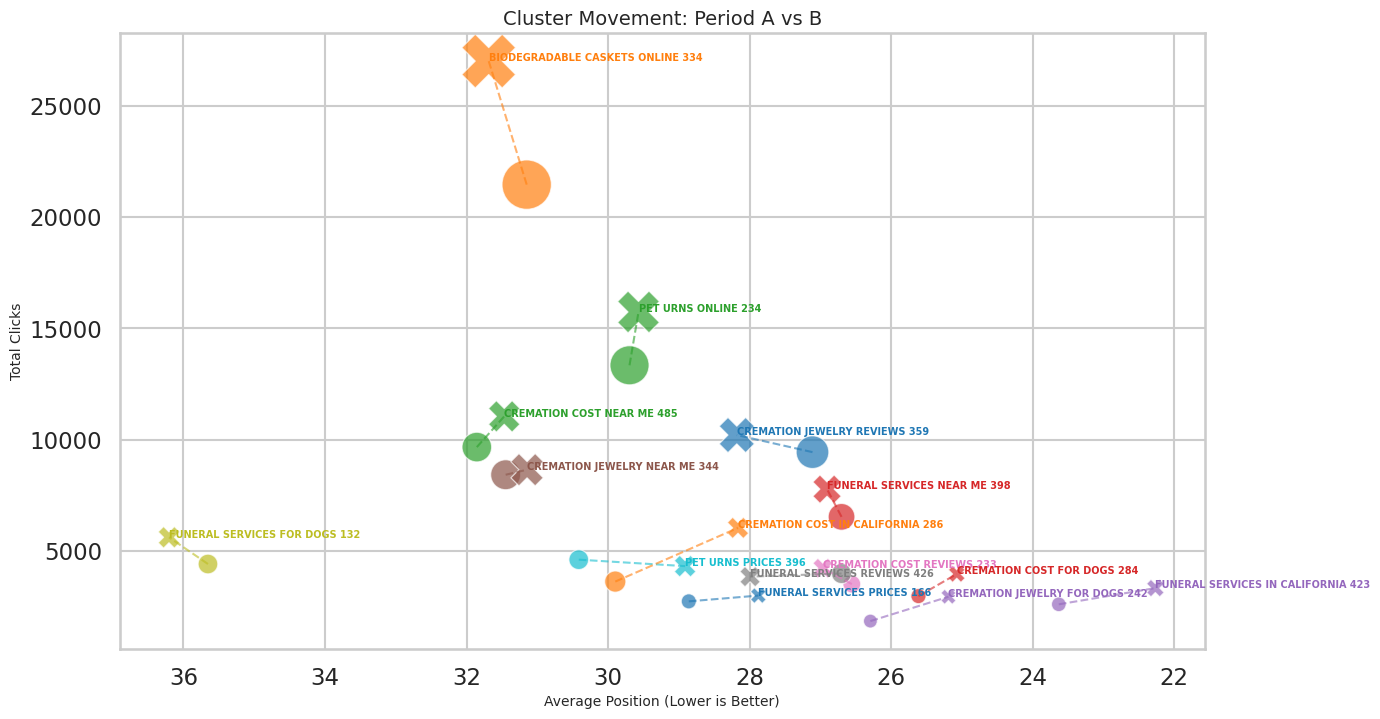

In [21]:
# Visual 3: Movement Trajectory (A -> B)
if df_clustered is not None:
    plot_trajectory(cluster_m, "Cluster Movement: Period A vs B", text_fontsize=7, xlabel_fontsize=10, ylabel_fontsize=10)